In [164]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from shapely.geometry import Polygon
from shapely import affinity


def sort_clockwise(vertices):
    centroid = np.mean(vertices, axis=0)
    
    def angle(vertex):
        dx, dy = vertex[0] - centroid[0], vertex[1] - centroid[1]
        return np.arctan2(dy, dx)
    
    vertices = sorted(vertices, key=angle, reverse=True)
    
    distances = np.linalg.norm(vertices, axis=1)
    min_index = np.argmin(distances)
    vertices = np.roll(vertices, -min_index, axis=0)
    return np.array(vertices)

def adjust_obbox_annotations(tracks, within, initial, crop_width, crop_height):
    tracks_save = tracks[within, :].copy() # x, y, w, h, a, s

    tracks_save[:, 0] = tracks_save[:, 0] - initial[0] # x', y, w, h, a, s
    tracks_save[:, 1] = tracks_save[:, 1] - initial[1] # x', y', w, h, a, s

    build_obb = lambda x, y, w, h, a, _ : affinity.translate(affinity.rotate(Polygon([(-w/2, -h/2), (w/2, -h/2), (w/2, h/2), (-w/2, h/2)]), a, use_radians=False), x, y)
    boundary = build_obb(crop_width / 2, crop_height / 2, crop_width, crop_height, 0, 0)

    def process_outside(obb):
        sh_obb = build_obb(*obb)

        if np.isclose(boundary.intersection(sh_obb).area, sh_obb.area):
            return sh_obb
        
        max_area = 0
        best_rect = None
        for angle in np.linspace(0, 180 - 0.5, 180, endpoint=True):
            rotated = affinity.rotate(sh_obb, angle, use_radians=False)
            minx, miny, maxx, maxy = rotated.bounds
            diag = np.linalg.norm(((maxx-minx), (maxy-miny)))

            def objective(params):
                new_obb = build_obb(*params, angle, 0) 
                return new_obb.union(sh_obb.intersection(boundary)).area - 0.3 * new_obb.intersection(sh_obb).intersection(boundary).area - 0.7 * new_obb.intersection(sh_obb).area
            
            result = optimize.minimize(
                objective, # minimize union and maximize intersection with original obbox
                [rotated.centroid.x, rotated.centroid.y, diag * np.sin(obb[-2]), diag * np.cos(obb[-2])], # Start from original obbox
                bounds=[
                    (minx, maxx),
                    (miny, maxy), 
                    (1, diag),
                    (1, diag), 
                ],
                constraints={'type' : 'eq', 'fun' : lambda params : build_obb(*params, angle, 0).intersection(boundary).area - build_obb(*params, angle, 0).area} # Be inside the crop
            )

            rect = build_obb(*result.x, angle, 0)
            if rect.intersection(sh_obb).intersection(boundary).area > max_area:
                max_area = rect.intersection(sh_obb).intersection(boundary).area
                best_rect = rect
        
        if best_rect is None:
            try:
                minx, miny, maxx, maxy = sh_obb.intersection(boundary).bounds
                best_rect = Polygon([(minx, miny), (minx, maxy), (maxx, maxy), (maxx, miny), (minx, miny)])
            except:
                minx = max(minx - 1, 0)
                miny = max(miny - 1, 0)
                maxx = min(maxx, crop_width)
                maxy = min(maxy, crop_height)
                return Polygon([(minx, miny), (minx, maxy), (maxx, maxy), (maxx, miny), (minx, miny)])
        
        return best_rect
    
    tracks_save = np.asarray([sort_clockwise(process_outside(obb).exterior.coords[:-1]) for obb in tracks_save]).reshape(-1, 8)

    return tracks_save # Normalized (x1, y1, x2, y2, x3, y3, x4, y4)


/home/ignasi/.local/lib/python3.11/site-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


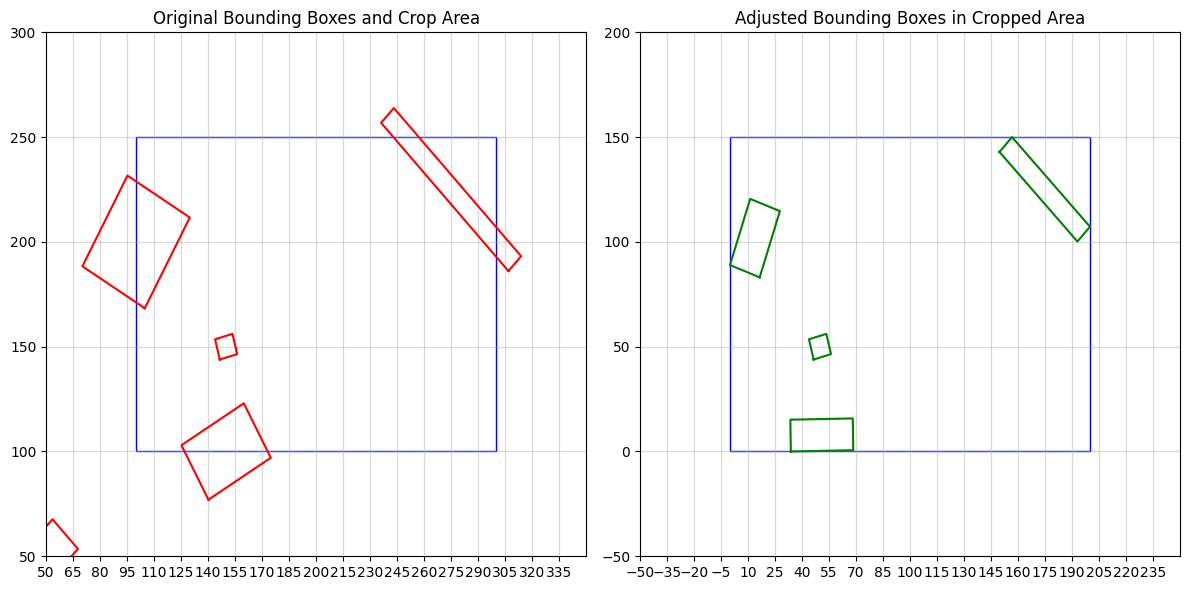

In [165]:
# x, y, w, h, angle, score
tracks = np.array([
    [50, 50, 30, 20, 45, 0.9],  # This will be outside the crop
    [150, 100, 40, 30, 30, 0.85],
    [100, 200, 50, 40, 60, 0.7],
    [150, 150, 10, 10, 15, 0],
    [275, 225, 10, 100, 45, 0]
])

initial = (100, 100)
crop_width = 200 
crop_height = 150

within = np.array([False, True, True, True, True]) # False is outside

tracks_save = adjust_obbox_annotations(tracks, within, initial, crop_width, crop_height)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].set_title("Original Bounding Boxes and Crop Area")
ax[0].set_xlim(initial[0] - 50, initial[0] + crop_width + 50)
ax[0].set_ylim(initial[1] - 50, initial[1] + crop_height + 50)

ax[0].add_patch(plt.Rectangle((initial[0], initial[1]), crop_width, crop_height, linewidth=1, edgecolor='blue', facecolor='none', label='Crop Area'))

for track in tracks:
    x, y, w, h, angle, score = track
    rect = Polygon([(-w / 2, -h / 2), (w / 2, -h / 2), (w / 2, h / 2), (-w / 2, h / 2)])
    rotated_rect = affinity.rotate(rect, angle, use_radians=False)
    translated_rect = affinity.translate(rotated_rect, xoff=x, yoff=y)
    ax[0].plot(*translated_rect.exterior.xy, color='red', label='Original Bounding Boxes')

start, stop = ax[0].get_xlim()
ticks = np.arange(start, stop, 15)
ax[0].set_xticks(ticks)
ax[0].grid(which='major', alpha=0.5)

ax[1].set_title("Adjusted Bounding Boxes in Cropped Area")
ax[1].set_xlim(-50, crop_width + 50)
ax[1].set_ylim(-50, crop_height + 50)

ax[1].add_patch(plt.Rectangle((0, 0), crop_width, crop_height, linewidth=1, edgecolor='blue', facecolor='none', label='Crop Area'))

for track in tracks_save:
    track_reshaped = track.reshape(-1, 2)
    track_reshaped = np.vstack((track_reshaped, track_reshaped[0, :]))
    ax[1].plot(track_reshaped[:, 0], track_reshaped[:, 1], color='green', label='Adjusted Bounding Boxes')

ax[1].set_xticks(ticks - start - 50)
ax[1].grid(which='major', alpha=0.5)
plt.tight_layout()
plt.show()
